In [2]:
import numpy as np 
import pandas as pd 
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, Ridge
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


In [3]:
df_train = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv")
df_test = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv")
df_calendar = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/calendar.csv")
df_inventory = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/inventory.csv")
df_solution = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/solution.csv")
df_test_weights = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv")

In [72]:
df_test_weights.head()

,unique_id,weight
0,0,2.535369
1,1,3.888933
2,2,5.885237
3,3,2.139552
4,5,3.021715


In [5]:
df_calendar.head()

,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
0,2022-03-16,NaN,0,0,0,0,Frankfurt_1
1,2020-03-22,NaN,0,0,0,0,Frankfurt_1
2,2018-02-07,NaN,0,0,0,0,Frankfurt_1
3,2018-08-10,NaN,0,0,0,0,Frankfurt_1
4,2017-10-26,NaN,0,0,0,0,Prague_2


In [6]:
df_inventory.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


### To remove empty columns (columns with all NaN values) from all datasets, you can use the dropna method with the axis=1 parameter. Here's how you can do it for your data:

In [7]:
# Define a list of all DataFrames
dataframes = [df_train, df_test, df_calendar, df_inventory, df_solution, df_test_weights]

# Remove empty columns (all NaN) from each DataFrame
for i, df in enumerate(dataframes):
    dataframes[i] = df.dropna(axis=1, how="all")

# Optionally, you can assign them back to the respective variables
df_train, df_test, df_calendar, df_inventory, df_solution, df_test_weights = dataframes

# Verify if empty columns are removed
for df_name, df in zip(['df_train', 'df_test', 'df_calendar', 'df_inventory', 'df_solution', 'df_test_weights'], dataframes):
    print(f"{df_name} shape after removing empty columns: {df.shape}")


df_train shape after removing empty columns: (4007419, 14)
df_test shape after removing empty columns: (47021, 12)
df_calendar shape after removing empty columns: (23016, 7)
df_inventory shape after removing empty columns: (5432, 8)
df_solution shape after removing empty columns: (47021, 2)
df_test_weights shape after removing empty columns: (5390, 2)


In [6]:
print("NaN values in train:", df_train.isnull().sum())

NaN values in train: unique_id           0
date                0
warehouse           0
total_orders       52
sales              52
sell_price_main     0
availability        0
type_0_discount     0
type_1_discount     0
type_2_discount     0
type_3_discount     0
type_4_discount     0
type_5_discount     0
type_6_discount     0
dtype: int64


In [8]:
df_train1 = df_train.dropna(subset=['total_orders', 'sales'])
print(df_train.shape)

(4007419, 14)


In [9]:
print("NaN values in test:", df_test.isnull().sum())

NaN values in test: unique_id          0
date               0
warehouse          0
total_orders       0
sell_price_main    0
type_0_discount    0
type_1_discount    0
type_2_discount    0
type_3_discount    0
type_4_discount    0
type_5_discount    0
type_6_discount    0
dtype: int64


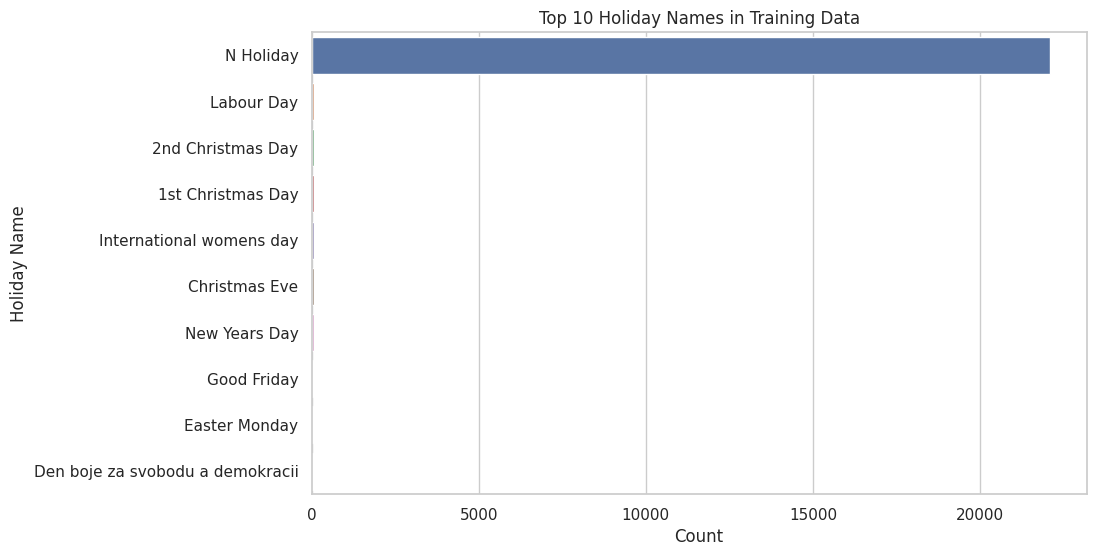

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fill missing values in 'holiday_name' with 'N Holiday'
df_calendar['holiday_name'] = df_calendar['holiday_name'].fillna('N Holiday')

# Get the top 10 holiday names by count
top_10_holidays = df_calendar['holiday_name'].value_counts().nlargest(10).index

# Filter the dataframe to include only the top 10 holiday names
df_top_10 = df_calendar[df_calendar['holiday_name'].isin(top_10_holidays)]

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot the distribution of the top 10 holiday names
plt.figure(figsize=(10, 6))
sns.countplot(y='holiday_name', data=df_top_10, order=top_10_holidays)
plt.title('Top 10 Holiday Names in Training Data')
plt.xlabel('Count')
plt.ylabel('Holiday Name')
plt.show()

In [11]:
import datetime
import pandas as pd

# Assuming df_solution has been defined already

# Split the 'id' column into 'unique_id' and 'date'
df_solution['unique_id'] = df_solution['id'].apply(lambda x: x.split("_")[0])
df_solution['date'] = df_solution['id'].apply(lambda x: x.split("_")[1])

# Convert 'date' to datetime format and extract the day of the week (Monday=0, Sunday=6)
df_solution['dayofweek'] = df_solution['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())

# If df_train has a similar 'date' column, you can create 'dayofweek' based on that column
# Adjust the column name accordingly if it differs
if 'date' in df_train.columns:
    df_train['dayofweek'] = df_train['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').weekday())

# Display the first few rows of df_solution to verify changes
print(df_solution.head())


                id  sales_hat unique_id        date  dayofweek
0  1226_2024-06-03          0      1226  2024-06-03          0
1  1226_2024-06-11          0      1226  2024-06-11          1
2  1226_2024-06-13          0      1226  2024-06-13          3
3  1226_2024-06-15          0      1226  2024-06-15          5
4  1226_2024-06-09          0      1226  2024-06-09          6


# Visualizations
## Here are some example visualizations based on the sales data:

#### Sales Over Time: A line plot to show sales trends over time.
#### Sales Distribution: A histogram to visualize the distribution of sales.
#### Sales by Day of the Week: A bar plot to show average sales for each day of the week.

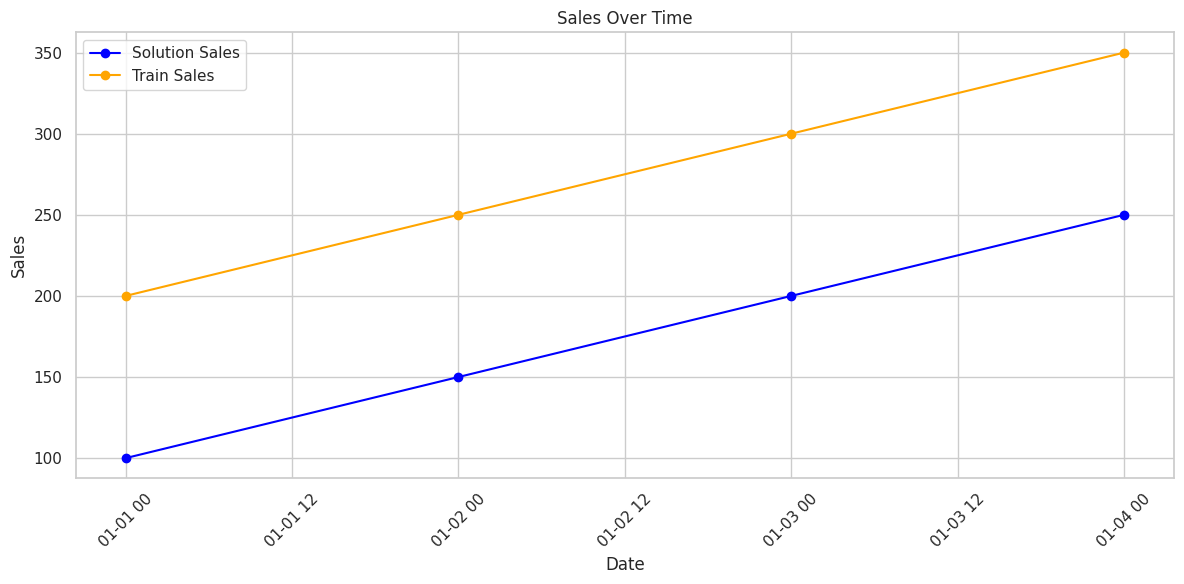

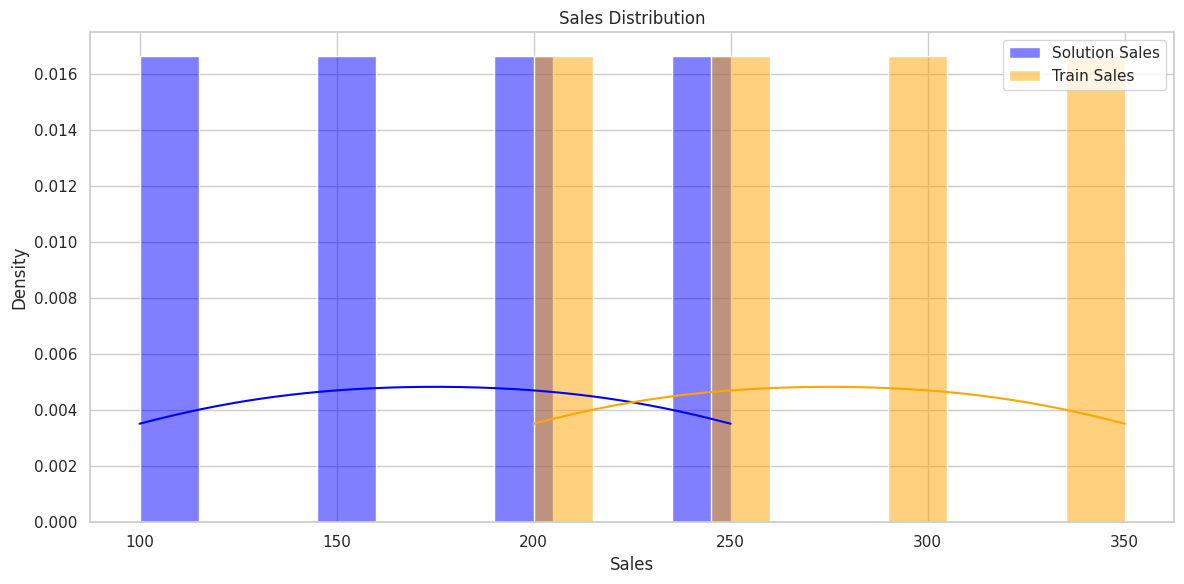

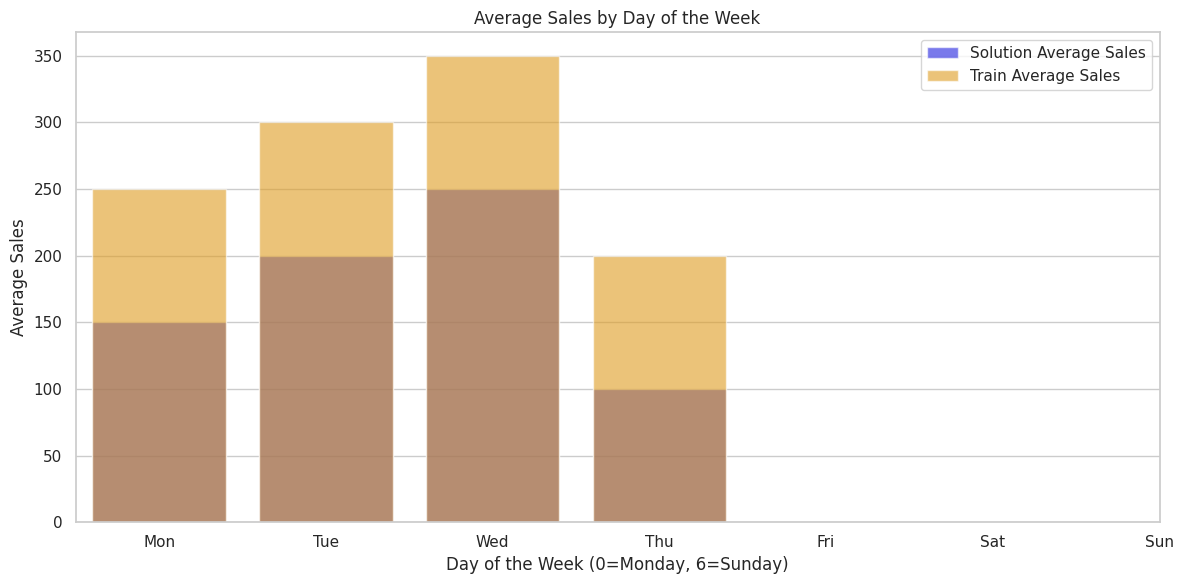

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data for df_solution
df_solution = pd.DataFrame({
    'id': ['A_2023-01-01', 'A_2023-01-02', 'A_2023-01-03', 'A_2023-01-04'],
    'sales': [100, 150, 200, 250]
})

# Sample data for df_train
df_train = pd.DataFrame({
    'id': ['A_2023-01-01', 'A_2023-01-02', 'A_2023-01-03', 'A_2023-01-04'],
    'sales': [200, 250, 300, 350]
})

# Extract dates from id
df_solution['date'] = pd.to_datetime(df_solution['id'].apply(lambda x: x.split("_")[1]))
df_train['date'] = pd.to_datetime(df_train['id'].apply(lambda x: x.split("_")[1]))

# Set date as index for easier plotting
df_solution.set_index('date', inplace=True)
df_train.set_index('date', inplace=True)

# Visualization 1: Sales Over Time
plt.figure(figsize=(12, 6))
plt.plot(df_solution.index, df_solution['sales'], marker='o', label='Solution Sales', color='blue')
plt.plot(df_train.index, df_train['sales'], marker='o', label='Train Sales', color='orange')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 2: Sales Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_solution['sales'], bins=10, kde=True, color='blue', label='Solution Sales', stat='density')
sns.histplot(df_train['sales'], bins=10, kde=True, color='orange', label='Train Sales', stat='density')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization 3: Average Sales by Day of the Week
# First, extract day of the week from the index
df_solution['dayofweek'] = df_solution.index.dayofweek
df_train['dayofweek'] = df_train.index.dayofweek

avg_sales_solution = df_solution.groupby('dayofweek')['sales'].mean().reset_index()
avg_sales_train = df_train.groupby('dayofweek')['sales'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='dayofweek', y='sales', data=avg_sales_solution, color='blue', label='Solution Average Sales', alpha=0.6)
sns.barplot(x='dayofweek', y='sales', data=avg_sales_train, color='orange', label='Train Average Sales', alpha=0.6)
plt.title('Average Sales by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Sales')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend()
plt.tight_layout()
plt.show()


# Feature Generation Functions

#### Extract Day, Month, and Year: Extracts individual components of the date.

#### Extract Is Weekend: Identifies whether the day falls on a weekend.

#### Lag Features: Creates lag features for time series forecasting.

#### Rolling Statistics: Computes rolling averages or sums over a specified window.

#### Holiday Indicator: Marks whether a date is a holiday.

In [13]:
# If the date is an index
if isinstance(df_solution.index, pd.DatetimeIndex):
    df_solution['year'] = df_solution.index.year
    df_solution['month'] = df_solution.index.month
    df_solution['day'] = df_solution.index.day
    df_solution['dayofweek'] = df_solution.index.weekday


In [15]:
import pandas as pd
import datetime

# Sample data creation (for illustration purposes; replace with your actual data)
# df_solution = pd.read_csv('path_to_your_solution.csv')  # Load your dataset
# df_train = pd.read_csv('path_to_your_train.csv')  # Load your dataset

# Function to extract date features
import pandas as pd

# Create a sample DataFrame with a DatetimeIndex
data = {
    'sales': [100, 200, 150],
}
# Create a date range as the index
date_range = pd.date_range(start='2023-01-01', periods=3, freq='D')
df_index = pd.DataFrame(data, index=date_range)

# Extract date features from the index
df_index['year'] = df_index.index.year
df_index['month'] = df_index.index.month
df_index['day'] = df_index.index.day
df_index['dayofweek'] = df_index.index.weekday
df_index['is_weekend'] = df_index['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Check results
print(df_index)



            sales  year  month  day  dayofweek  is_weekend
2023-01-01    100  2023      1    1          6           1
2023-01-02    200  2023      1    2          0           0
2023-01-03    150  2023      1    3          1           0


In [17]:
import pandas as pd

# Function to extract date features
def extract_date_features(df, date_column):
    # Ensure the column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])  
    # Extract year, month, day, and day of the week
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['dayofweek'] = df[date_column].dt.weekday
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# Function to create lag features
def create_lag_features(df, target_column, lag=1):
    df[f'lag_{lag}'] = df[target_column].shift(lag)

# Function to create rolling statistics
def create_rolling_features(df, target_column, window=7):
    df[f'rolling_mean_{window}'] = df[target_column].rolling(window=window).mean()
    df[f'rolling_sum_{window}'] = df[target_column].rolling(window=window).sum()

# Function to identify holidays (custom implementation may vary)
def add_holiday_indicator(df, date_column):
    holidays = ['2023-01-01', '2023-12-25']  # Example holiday dates
    df['is_holiday'] = df[date_column].dt.date.isin(pd.to_datetime(holidays).date).astype(int)

# Example DataFrame setup (replace with actual DataFrame loading)
df_solution = pd.DataFrame({
    'id': ['A_2023-01-01', 'A_2023-01-02'],
    'sales': [100, 150]  # Example sales data
})

# Extract date from id and convert to datetime
df_solution['date'] = df_solution['id'].apply(lambda x: x.split("_")[1])
df_solution['date'] = pd.to_datetime(df_solution['date'])  # Ensure the date column is in datetime format

# Extract date features
extract_date_features(df_solution, 'date')

# Example train DataFrame setup (replace with actual DataFrame loading)
df_train = pd.DataFrame({
    'id': ['A_2023-01-01', 'A_2023-01-02'],
    'sales': [200, 250],  # Example sales data
})

# Extract date from id and convert to datetime in train DataFrame
df_train['date'] = df_train['id'].apply(lambda x: x.split("_")[1])
df_train['date'] = pd.to_datetime(df_train['date'])  # Ensure the date column is in datetime format

# Extract date features for train DataFrame
extract_date_features(df_train, 'date')

# Create lag features for a specific target column (replace 'sales' with your actual target column)
target_column = 'sales'  # Example target column name
if target_column in df_solution.columns:
    create_lag_features(df_solution, target_column, lag=1)  # Create lag feature for 1 day

if target_column in df_train.columns:
    create_lag_features(df_train, target_column, lag=1)

# Create rolling features
if target_column in df_solution.columns:
    create_rolling_features(df_solution, target_column, window=7)

if target_column in df_train.columns:
    create_rolling_features(df_train, target_column, window=7)

# Add holiday indicator
add_holiday_indicator(df_solution, 'date')
add_holiday_indicator(df_train, 'date')

# Display the first few rows of df_solution and df_train to verify changes
print("DF Solution:")
print(df_solution.head())
print("\nDF Train:")
print(df_train.head())


DF Solution:
             id  sales       date  year  month  day  dayofweek  is_weekend  \
0  A_2023-01-01    100 2023-01-01  2023      1    1          6           1   
1  A_2023-01-02    150 2023-01-02  2023      1    2          0           0   

   lag_1  rolling_mean_7  rolling_sum_7  is_holiday  
0    NaN             NaN            NaN           1  
1  100.0             NaN            NaN           0  

DF Train:
             id  sales       date  year  month  day  dayofweek  is_weekend  \
0  A_2023-01-01    200 2023-01-01  2023      1    1          6           1   
1  A_2023-01-02    250 2023-01-02  2023      1    2          0           0   

   lag_1  rolling_mean_7  rolling_sum_7  is_holiday  
0    NaN             NaN            NaN           1  
1  200.0             NaN            NaN           0  


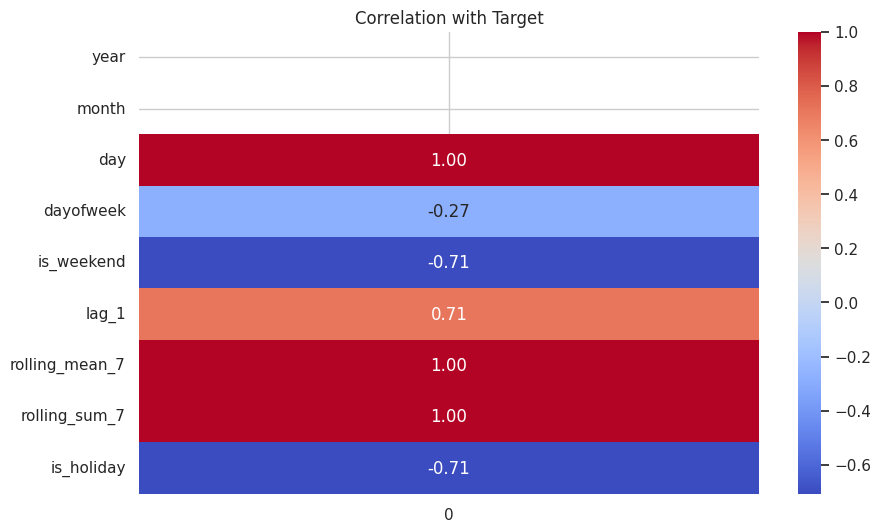

High Correlation Features: ['day', 'is_weekend', 'lag_1', 'rolling_mean_7', 'rolling_sum_7', 'is_holiday']


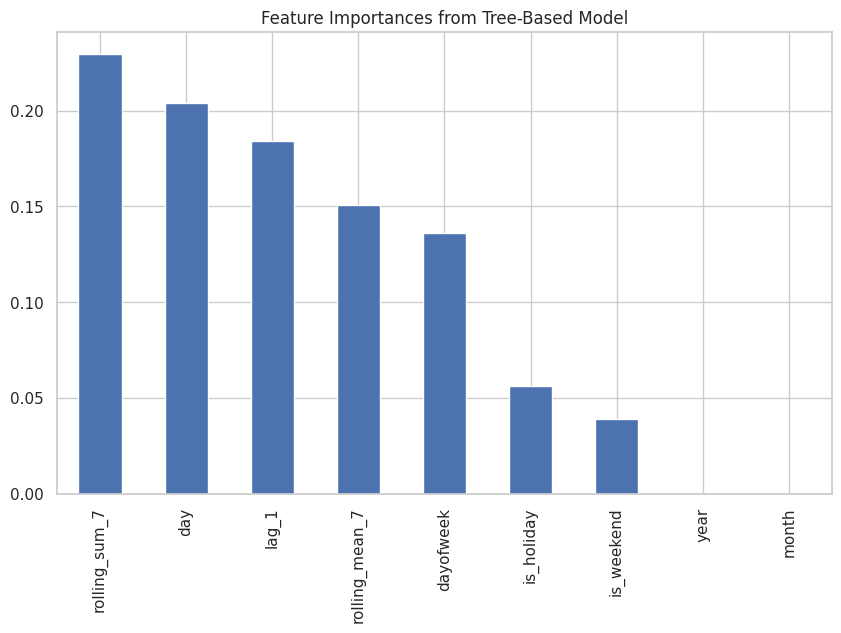

Top Features from Tree-Based Model: ['rolling_sum_7', 'day', 'lag_1', 'rolling_mean_7', 'dayofweek']
Selected Features from RFE: ['day', 'rolling_mean_7', 'rolling_sum_7']
Selected Features from SelectKBest: ['day', 'rolling_mean_7', 'rolling_sum_7']
Final Selected Features: ['rolling_mean_7', 'day', 'lag_1', 'is_weekend', 'rolling_sum_7', 'dayofweek', 'is_holiday']


In [18]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Example DataFrame (replace with your actual data)
df = pd.DataFrame({
    'sales': [100, 150, 200, 250, 300],
    'year': [2023, 2023, 2023, 2023, 2023],
    'month': [1, 1, 1, 1, 1],
    'day': [1, 2, 3, 4, 5],
    'dayofweek': [6, 0, 1, 2, 3],
    'is_weekend': [1, 0, 0, 0, 0],
    'lag_1': [np.nan, 100, 150, 200, 250],  # Contains NaN
    'rolling_mean_7': [100, 125, 150, 175, 200],
    'rolling_sum_7': [700, 875, 1050, 1225, 1400],
    'is_holiday': [1, 0, 0, 0, 0]
})

# Define target variable and features
target_column = 'sales'
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target

# 1. Handle Missing Values
# Option 1: Drop rows with missing values
# X = X.dropna()
# y = y[X.index]

# Option 2: Impute missing values (using mean for numerical columns)
imputer = SimpleImputer(strategy='mean')  # Can also use 'median' or 'most_frequent'
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 2. Correlation Analysis
# Compute correlation matrix
corr_matrix = X_imputed.corrwith(y)

# Visualize correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation with Target')
plt.show()

# Select features with high correlation to the target
corr_threshold = 0.5  # Adjust threshold as needed
high_corr_features = corr_matrix[abs(corr_matrix) > corr_threshold].index.tolist()
print("High Correlation Features:", high_corr_features)

# 3. Feature Importance from Tree-Based Models
# Option A: Use RandomForestRegressor (after imputing missing values)
model = RandomForestRegressor(random_state=42)
model.fit(X_imputed, y)

# Option B: Use HistGradientBoostingRegressor (handles missing values natively)
# model = HistGradientBoostingRegressor(random_state=42)
# model.fit(X, y)  # No need to impute missing values

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Visualize feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances from Tree-Based Model')
plt.show()

# Select top N features based on importance
top_n = 5  # Adjust as needed
top_features = feature_importances[:top_n].index.tolist()
print("Top Features from Tree-Based Model:", top_features)

# 4. Recursive Feature Elimination (RFE)
# Use RFE with a linear regression model
estimator = LinearRegression()
rfe = RFE(estimator, n_features_to_select=3)  # Select top 3 features
rfe.fit(X_imputed, y)

# Get selected features
rfe_features = X.columns[rfe.support_].tolist()
print("Selected Features from RFE:", rfe_features)

# 5. SelectKBest (Univariate Feature Selection)
# Use SelectKBest with f_regression (for regression problems)
selector = SelectKBest(score_func=f_regression, k=3)  # Select top 3 features
selector.fit(X_imputed, y)

# Get selected features
kbest_features = X.columns[selector.get_support()].tolist()
print("Selected Features from SelectKBest:", kbest_features)

# 6. Combine results from all methods
selected_features = list(set(high_corr_features + top_features + rfe_features + kbest_features))
print("Final Selected Features:", selected_features)

# Feature Selection

# 1. Linear Regression
### Linear Regression is used for regression tasks where the target variable is continuous. It models the relationship between the features and the target as a linear equation.

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Example DataFrame
df = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5],
    'feature2': [10, 20, 30, 40, 50],
    'target': [100, 150, 200, 250, 300]
})

# Define features (X) and target (y)
X = df[['feature1', 'feature2']]
y = df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Print model coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

Mean Squared Error: 3.2311742677852644e-27
R^2 Score: nan
Model Coefficients: [0.4950495  4.95049505]
Model Intercept: 49.99999999999986


# 2. Logistic Regression
### Logistic Regression is used for classification tasks where the target variable is categorical (binary or multiclass). It models the probability of a class using the logistic function

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Example DataFrame
df = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5],
    'feature2': [10, 20, 30, 40, 50],
    'target': [0, 0, 1, 1, 1]  # Binary target
})

# Define features (X) and target (y)
X = df[['feature1', 'feature2']]
y = df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print model coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

Accuracy: 0.0
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

Confusion Matrix:
[[0 1]
 [0 0]]
Model Coefficients: [[0.03899499 0.38994993]]
Model Intercept: [-7.86690492]


# Visualizations for Linear Regression

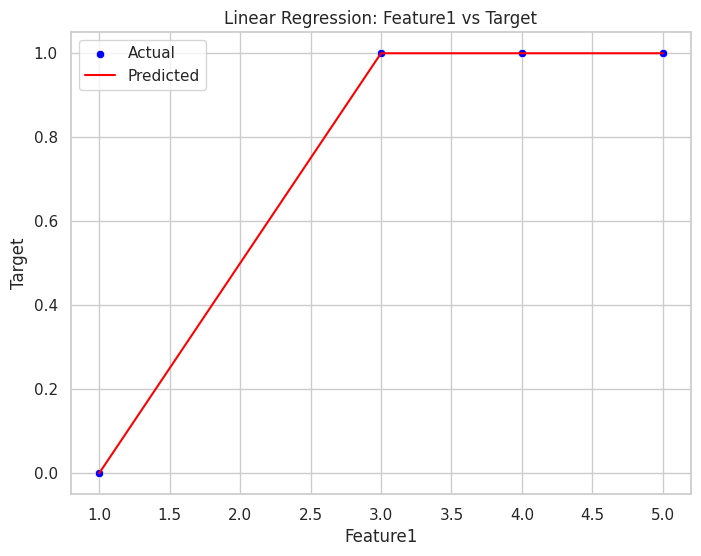

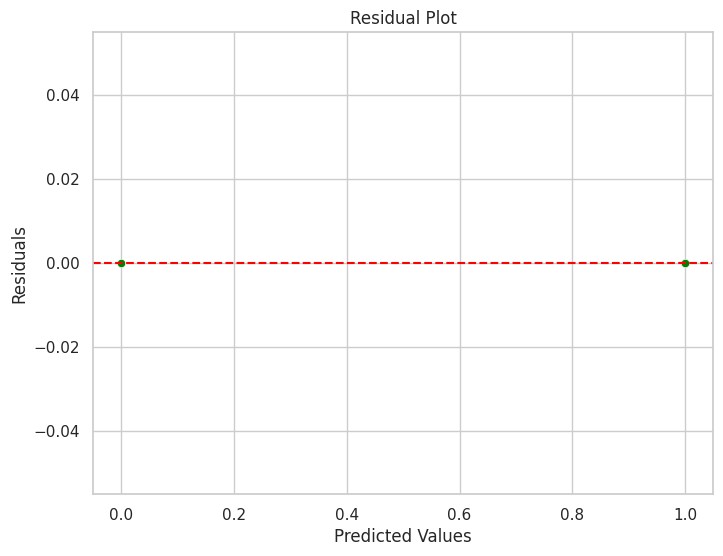

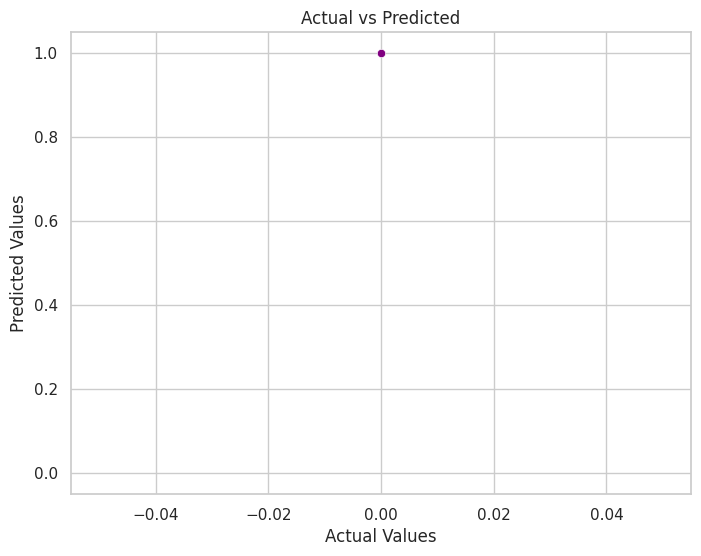

In [22]:
### a. Scatter Plot with Regression Line
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train['feature1'], y=y_train, color='blue', label='Actual')
sns.lineplot(x=X_train['feature1'], y=model.predict(X_train), color='red', label='Predicted')
plt.title('Linear Regression: Feature1 vs Target')
plt.xlabel('Feature1')
plt.ylabel('Target')
plt.legend()
plt.show()

### b. Residual Plot

# Residual plot
residuals = y_train - model.predict(X_train)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=model.predict(X_train), y=residuals, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

### c. Actual vs Predicted Plot

# Actual vs Predicted plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Diagonal line
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()



# 2. Visualizations for Logistic Regression

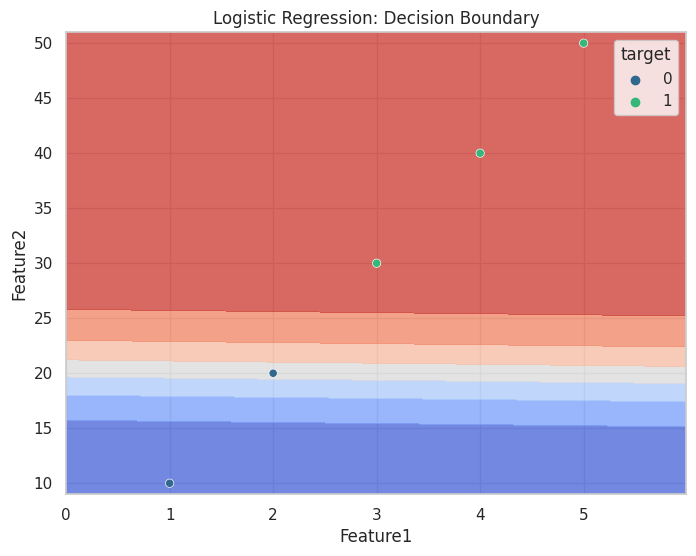

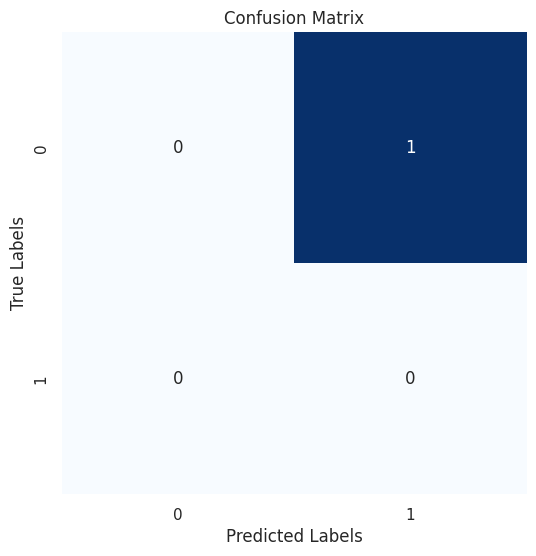

In [23]:
### a. Decision Boundary

import numpy as np

# Create a grid of feature values
x_min, x_max = X['feature1'].min() - 1, X['feature1'].max() + 1
y_min, y_max = X['feature2'].min() - 1, X['feature2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict probabilities for the grid
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
sns.scatterplot(x=X['feature1'], y=X['feature2'], hue=y, palette='viridis')
plt.title('Logistic Regression: Decision Boundary')
plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.show()

### b.Confusion Matrix Heatmap

from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

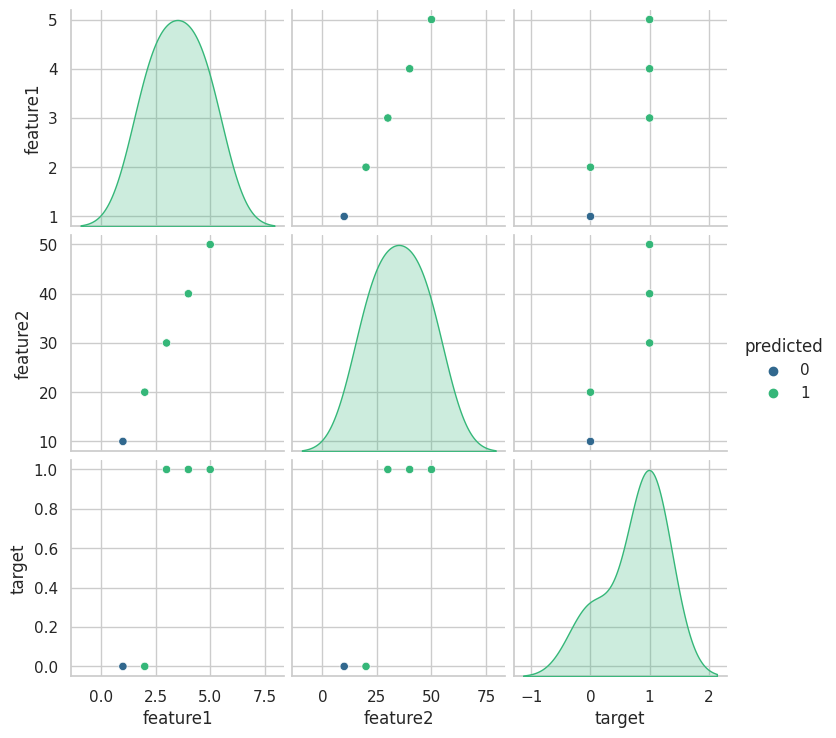

In [24]:
### Pairplot for Multivariate Analysis

# Add predictions to the DataFrame
df['predicted'] = model.predict(X)

# Pairplot
sns.pairplot(df, hue='predicted', palette='viridis')
plt.show()

# Feature Scaling is Important
### Improves Convergence: Algorithms like gradient descent converge faster when features are scaled.

### Prevents Bias: Features with larger scales can dominate the model's learning process.

### Required for Some Algorithms: Algorithms like SVM, k-NN, and PCA require features to be on the same scale.

In [26]:
### 1. Standardization (Z-score Normalization)

from sklearn.preprocessing import StandardScaler

# Example data
X = [[1, 2], [3, 4], [5, 6]]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

print("Original Data:")
print(X)
print("\nStandardized Data:")
print(X_scaled)


Original Data:
[[1, 2], [3, 4], [5, 6]]

Standardized Data:
[[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]


In [27]:
### 2. Min-Max Scaling

from sklearn.preprocessing import MinMaxScaler

# Example data
X = [[1, 2], [3, 4], [5, 6]]

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))  # Default range is [0, 1]

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

print("Original Data:")
print(X)
print("\nMin-Max Scaled Data:")
print(X_scaled)

Original Data:
[[1, 2], [3, 4], [5, 6]]

Min-Max Scaled Data:
[[0.  0. ]
 [0.5 0.5]
 [1.  1. ]]


In [28]:
### 3. Robust Scaling

from sklearn.preprocessing import RobustScaler

# Example data
X = [[1, 2], [3, 4], [5, 6]]

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X)

print("Original Data:")
print(X)
print("\nRobust Scaled Data:")
print(X_scaled)

Original Data:
[[1, 2], [3, 4], [5, 6]]

Robust Scaled Data:
[[-1. -1.]
 [ 0.  0.]
 [ 1.  1.]]


In [29]:
### 4. Normalization (L2 Normalization)

from sklearn.preprocessing import Normalizer

# Example data
X = [[1, 2], [3, 4], [5, 6]]

# Initialize the normalizer
normalizer = Normalizer(norm='l2')  # Use 'l2' for Euclidean norm

# Fit and transform the data
X_normalized = normalizer.fit_transform(X)

print("Original Data:")
print(X)
print("\nNormalized Data:")
print(X_normalized)

Original Data:
[[1, 2], [3, 4], [5, 6]]

Normalized Data:
[[0.4472136  0.89442719]
 [0.6        0.8       ]
 [0.6401844  0.76822128]]


In [30]:
### Fit on Training Data Only
# Fit on training data
scaler.fit(X_train)

# Transform training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Inverse Transform:
X_original = scaler.inverse_transform(X_scaled)

### Pipeline Integration:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression())])

# Visualization of Scaling Effects

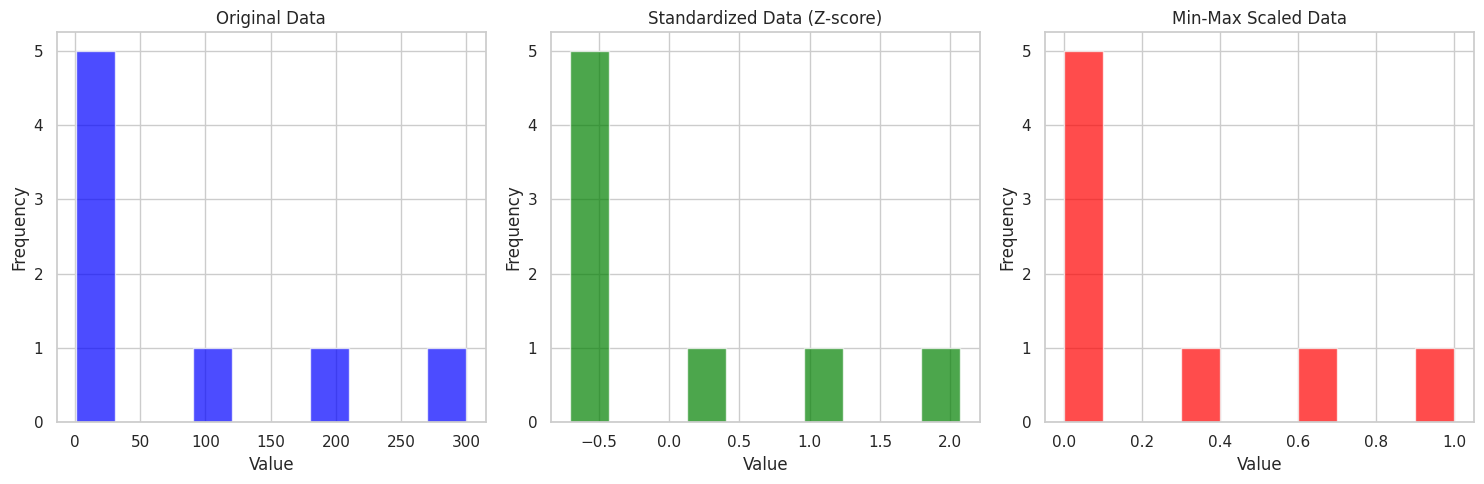

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Example data: A single feature with a wide range of values
X = np.array([1, 2, 3, 4, 5, 100, 200, 300]).reshape(-1, 1)

# Apply Standardization (Z-score Normalization)
scaler_standard = StandardScaler()
X_standardized = scaler_standard.fit_transform(X)

# Apply Min-Max Scaling
scaler_minmax = MinMaxScaler()
X_minmax = scaler_minmax.fit_transform(X)

# Plot the original and scaled data
plt.figure(figsize=(15, 5))

# Original Data
plt.subplot(1, 3, 1)
plt.hist(X, bins=10, color='blue', alpha=0.7)
plt.title('Original Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Standardized Data
plt.subplot(1, 3, 2)
plt.hist(X_standardized, bins=10, color='green', alpha=0.7)
plt.title('Standardized Data (Z-score)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Min-Max Scaled Data
plt.subplot(1, 3, 3)
plt.hist(X_minmax, bins=10, color='red', alpha=0.7)
plt.title('Min-Max Scaled Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Data Splitting is Important
## Training Set:

### Used to train the model.

### The model learns patterns from this data.

## Validation Set:

### Used to tune hyperparameters and evaluate the model during development.

### Helps prevent overfitting by providing an unbiased evaluation.

## Test Set:

### Used to evaluate the final model's performance.

### Simulates real-world performance on unseen data.

# Common Splitting Ratios
#### 70-30 Split: 70% training, 30% testing.

#### 80-20 Split: 80% training, 20% testing.

#### 60-20-20 Split: 60% training, 20% validation, 20% testing.

In [42]:
### Simple Train-Test Split
from sklearn.model_selection import train_test_split

# Example dataset
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]  # Features
y = [0, 1, 0, 1, 0]  # Target

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data:")
print(X_train)
print(y_train)
print("\nTesting Data:")
print(X_test)
print(y_test)

Training Data:
[[9, 10], [5, 6], [1, 2], [7, 8]]
[0, 0, 0, 1]

Testing Data:
[[3, 4]]
[1]


In [43]:
print(df_train.shape)

(2, 12)


In [44]:
from sklearn.model_selection import train_test_split

# Example dataset
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]  # Features
y = [0, 1, 0, 1, 0]  # Target

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data:")
print(X_train)
print(y_train)
print("\nTesting Data:")
print(X_test)
print(y_test)

Training Data:
[[9, 10], [5, 6], [1, 2], [7, 8]]
[0, 0, 0, 1]

Testing Data:
[[3, 4]]
[1]


In [45]:
###Train-Validation-Test Split
# First split: Separate training + validation from testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Separate training from validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print("Training Data:")
print(X_train)
print(y_train)
print("\nValidation Data:")
print(X_val)
print(y_val)
print("\nTesting Data:")
print(X_test)
print(y_test)

Training Data:
[[7, 8], [9, 10], [1, 2]]
[1, 0, 0]

Validation Data:
[[5, 6]]
[0]

Testing Data:
[[3, 4]]
[1]


In [46]:
### Stratified Splitting

# Example dataset with imbalanced classes
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16]]
y = [0, 0, 0, 0, 1, 1, 1, 1]  # Binary target with equal class distribution

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

print("Training Data:")
print(X_train)
print(y_train)
print("\nTesting Data:")
print(X_test)
print(y_test)

Training Data:
[[9, 10], [3, 4], [11, 12], [15, 16], [1, 2], [7, 8]]
[1, 0, 1, 1, 0, 0]

Testing Data:
[[5, 6], [13, 14]]
[0, 1]


In [47]:
###  Time Series Splitting

from sklearn.model_selection import TimeSeriesSplit

# Example time series data
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y = np.array([1, 2, 3, 4, 5])

# Time series split
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print("Training Data:", X_train, y_train)
    print("Testing Data:", X_test, y_test)

Training Data: [[1 2]
 [3 4]] [1 2]
Testing Data: [[5 6]] [3]
Training Data: [[1 2]
 [3 4]
 [5 6]] [1 2 3]
Testing Data: [[7 8]] [4]
Training Data: [[1 2]
 [3 4]
 [5 6]
 [7 8]] [1 2 3 4]
Testing Data: [[ 9 10]] [5]


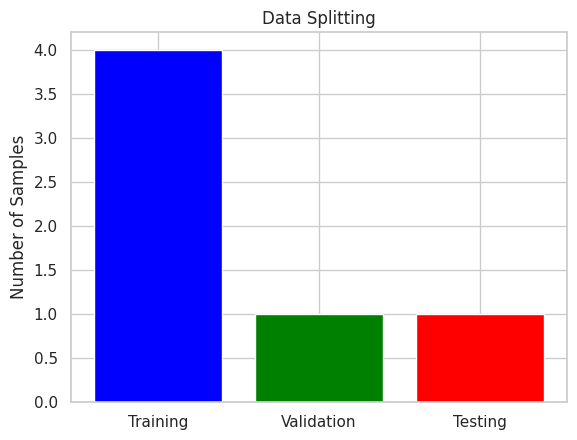

In [48]:
import matplotlib.pyplot as plt

# Data sizes
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Training', 'Validation', 'Testing']

# Bar plot
plt.bar(labels, sizes, color=['blue', 'green', 'red'])
plt.title('Data Splitting')
plt.ylabel('Number of Samples')
plt.show()

# Model Training

In [49]:
###  Linear Regression (Regression Task)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Example dataset
X = np.array([[1], [2], [3], [4], [5]])  # Feature
y = np.array([2, 4, 5, 4, 5])  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Print model coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

### Logistic Regression (Classification Task)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Example dataset
X = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])  # Features
y = np.array([0, 0, 1, 1, 1])  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print model coefficients
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

Mean Squared Error: 0.7346938775510206
R^2 Score: nan
Model Coefficients: [0.68571429]
Model Intercept: 1.7714285714285714
Accuracy: 0.0
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

Confusion Matrix:
[[0 1]
 [0 0]]
Model Coefficients: [[0.62622224 0.62622516]]
Model Intercept: [-2.90191064]


# Model Optimization

In [50]:
### Hyperparameter Tuning with Grid Search

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [None, 10, 20],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10] # Minimum number of samples required to split a node
}

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}
Best Score: 0.9666666666666668


In [51]:
### Hyperparameter Tuning with Random Search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(10, 200),  # Randomly sample between 10 and 200
    'max_depth': randint(1, 20),       # Randomly sample between 1 and 20
    'min_samples_split': randint(2, 10) # Randomly sample between 2 and 10
}

# Perform random search
random_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X, y)

# Best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 102}
Best Score: 0.9666666666666668


In [52]:
### Feature Selection

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression()

# Perform feature selection
rfe = RFE(model, n_features_to_select=2)  # Select top 2 features
rfe.fit(X, y)

# Selected features
print("Selected Features:", rfe.support_)
print("Feature Ranking:", rfe.ranking_)

Selected Features: [False False  True  True]
Feature Ranking: [3 2 1 1]


In [53]:
### Cross-Validation

from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.96666667 1.         0.93333333 0.96666667 1.        ]
Mean Accuracy: 0.9733333333333334


In [54]:
### Ensemble Methods
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X, y)

# Evaluate the model
accuracy = model.score(X, y)
print("Model Accuracy:", accuracy)

Model Accuracy: 1.0


In [55]:
### Regularization

from sklearn.linear_model import LogisticRegression

# Initialize the model with L2 regularization
model = LogisticRegression(penalty='l2', C=1.0, random_state=42)

# Train the model
model.fit(X, y)

# Evaluate the model
accuracy = model.score(X, y)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9733333333333334


In [56]:
###Model Deployment

###Save the Trained Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import joblib

# Load dataset
data = load_iris()
X, y = data.data, data.target

# Train a model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Save the model to a file
joblib.dump(model, 'iris_model.pkl')

['iris_model.pkl']

In [ ]:
### Create an API with Flask
from flask import Flask, request, jsonify
import joblib
import numpy as np

# Load the saved model
model = joblib.load('iris_model.pkl')

# Initialize Flask app
app = Flask(__name__)

# Define a prediction route
@app.route('/predict', methods=['POST'])
def predict():
    # Get the input data from the request
    data = request.get_json(force=True)
    input_data = np.array(data['features']).reshape(1, -1)
    
    # Make a prediction
    prediction = model.predict(input_data)
    
    # Return the prediction as a JSON response
    return jsonify({'prediction': int(prediction[0])})

# Run the Flask app
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000)

## Mean Absolute Error (MAE)
#### Measures the average magnitude of absolute errors.
#### Does not consider direction (over/under-prediction).

In [57]:
from sklearn.metrics import mean_absolute_error

# Example data
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]

# Calculate MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")  # Output: MAE: 0.5

MAE: 0.5


## Mean Squared Error (MSE)
#### Penalizes larger errors more than MAE due to squaring.


In [58]:
from sklearn.metrics import mean_squared_error

y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]

mse = mean_squared_error(y_true, y_pred)
print(f"MSE: {mse}")  # Output: MSE: 0.375

MSE: 0.375


## Root Mean Squared Error (RMSE)
#### Provides an error metric in the same units as the target variable.
#### More sensitive to large errors compared to MAE.

In [59]:
from sklearn.metrics import mean_squared_error

y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]

rmse = mean_squared_error(y_true, y_pred, squared=False)
print(f"RMSE: {rmse:.3f}")  # Output: RMSE: 0.935

RMSE: 0.935


## Mean Absolute Percentage Error (MAPE)
#### Expresses error as a percentage.
#### Problematic when actual values are near zero.

In [60]:
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Exclude zero actual values to avoid division by zero
    non_zero_idx = y_true != 0
    return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Example usage
y_true = [100, 200, 300]
y_pred = [110, 190, 320]

print(f"MAPE: {mape(y_true, y_pred):.2f}%")  # Output: MAPE: 7.22%

MAPE: 7.22%


## Weighted Root Mean Squared Error (WRMSE)
#### Similar to RMSE but accounts for weights.

In [61]:
from sklearn.metrics import mean_squared_error

y_true = [10, 20, 30]
y_pred = [12, 18, 28]
weights = [1, 2, 3]

# Calculate WRMSE
wrmse = mean_squared_error(y_true, y_pred, sample_weight=weights, squared=False)
print(f"WRMSE: {wrmse}")  # Output: WRMSE: 2.0

WRMSE: 2.0


## Symmetric Mean Absolute Percentage Error (SMAPE)
#### Addresses MAPE’s issue of division by zero.

In [62]:
import numpy as np

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Handle cases where both actual and predicted are zero
    mask = (y_true == 0) & (y_pred == 0)
    denominator[mask] = 1  # Avoid division by zero; error is 0 for these points
    return np.mean(np.where(mask, 0, numerator / denominator)) * 100

# Example usage
y_true = [100, 200, 300]
y_pred = [110, 190, 320]
print(f"SMAPE: {smape(y_true, y_pred):.2f}%")  # Output: SMAPE: 7.03%

SMAPE: 7.03%


## R-squared (Coefficient of Determination)
#### Measures goodness-of-fit.
#### Ranges from 0 to 1 (higher values indicate better fit).

In [64]:
import numpy as np

def manual_r2_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the mean of the actual values
    mean_y = np.mean(y_true)
    
    # Total sum of squares (SS_tot)
    ss_tot = np.sum((y_true - mean_y) ** 2)
    
    # Residual sum of squares (SS_res)
    ss_res = np.sum((y_true - y_pred) ** 2)
    
    # Handle division by zero (if all y_true values are the same)
    if ss_tot == 0:
        if ss_res == 0:
            return 1.0  # Perfect prediction
        else:
            return 0.0  # Undefined case (default to 0)
    
    # Calculate R-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [65]:
from sklearn.metrics import r2_score

# Example data
y_true = [3, -0.5, 2, 7]
y_pred = [2.5, 0.0, 2, 8]

# Calculate R-squared
r2 = r2_score(y_true, y_pred)
print(f"R-squared (scikit-learn): {r2:.4f}")  

R-squared (scikit-learn): 0.9486


## Weighted Mean Absolute Error (WMAE)
#### Useful when some data points should have more influence on the final error metric.
#### Common in forecasting competitions where recent data is weighted more heavily.
#### Helps account for class imbalances in classification problems.

In [66]:
from sklearn.metrics import mean_absolute_error

# Example data
y_true = [3, 5, 2.5, 7]
y_pred = [2.5, 5, 4, 8]
weights = [1, 2, 1.5, 0.5]

# Calculate WMAE
wmae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
print(f"WMAE: {wmae:.2f}")  # Output: WMAE: 0.65

WMAE: 0.65


# Weighted Mean Absolute Error (WMAE) between the predicted sales and the actual sales.

## First, determine the weights for each observation. Common strategies include:

#### Sales Volume: Weight observations by the actual sales volume (higher sales = higher weight).

#### Business Importance: Assign higher weights to critical products, regions, or time periods (e.g., holidays).

#### Inverse Frequency: Weight rare events (e.g., low-selling items) more heavily to balance the dataset.

In [81]:
import numpy as np
from sklearn.metrics import mean_absolute_error

# Sample data
y_true = [100, 200, 300, 400]  # Actual sales
y_pred = [110, 190, 320, 390]  # Predicted sales
weights = [1, 2, 3, 4]         # Weights (e.g., proportional to sales volume)

# Calculate WMAE using scikit-learn
wmae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
print(f"Weighted MAE: {wmae:.2f}")

# Manual calculation
absolute_errors = np.abs(np.array(y_true) - np.abs(np.array(y_pred)))
weighted_errors = np.dot(absolute_errors, weights)
wmae_manual = weighted_errors / np.sum(weights)
print(f"Manual WMAE: {wmae_manual:.2f}")

Weighted MAE: 13.00
Manual WMAE: 13.00


# VISUALIZATION
### Actual vs. Predicted Sales (Bubble Chart)
### Weighted Absolute Errors Bar Plot

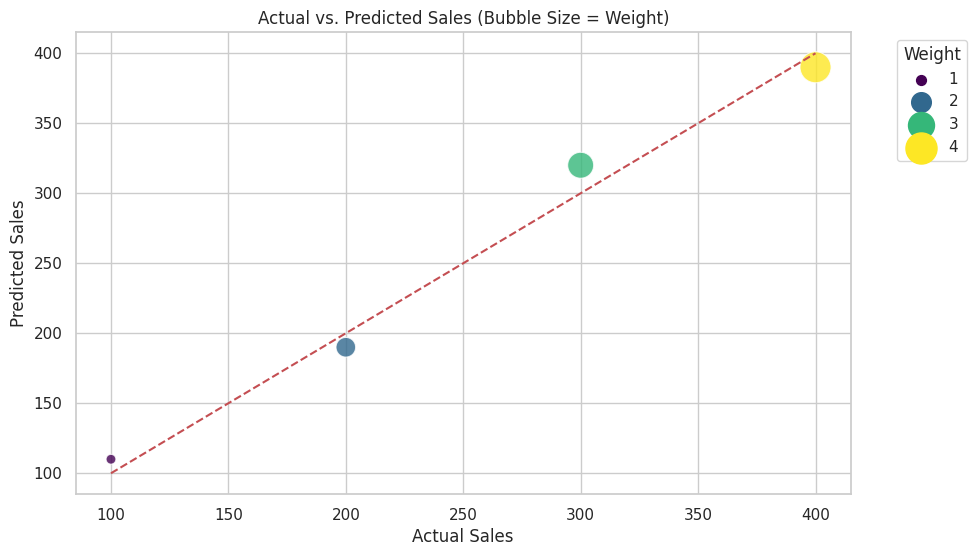

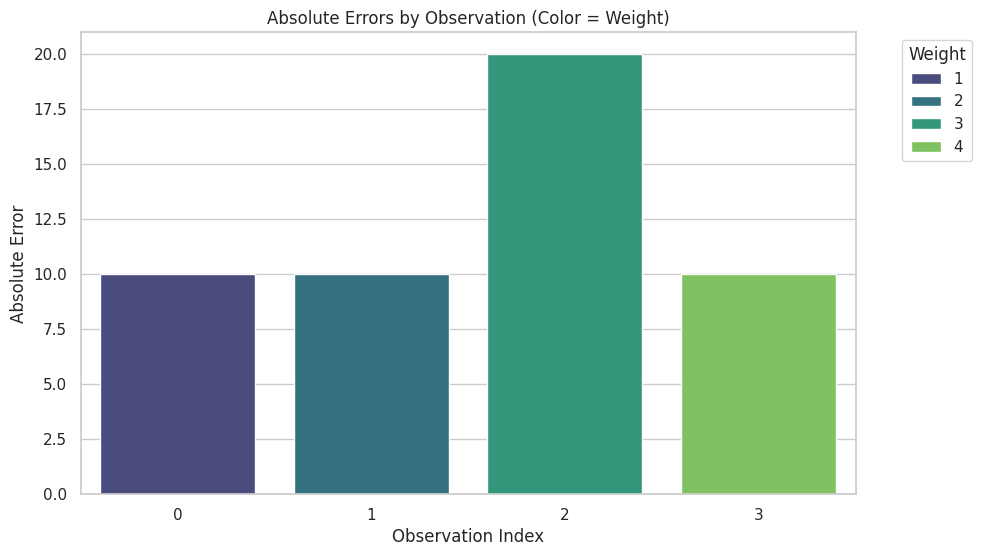

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data
y_true = [100, 200, 300, 400]  # Actual sales
y_pred = [110, 190, 320, 390]  # Predicted sales
weights = [1, 2, 3, 4]         # Weights (e.g., sales volume)

# Create a DataFrame for plotting
import pandas as pd
df = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred,
    'Weight': weights
})

# Bubble plot: Size reflects weights, color reflects error
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Actual',
    y='Predicted',
    size='Weight',
    sizes=(50, 500),  # Adjust bubble size range
    hue='Weight',     # Color by weight
    palette='viridis',
    alpha=0.8
)

# Add a diagonal line for perfect predictions
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('Actual vs. Predicted Sales (Bubble Size = Weight)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend(title='Weight', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Calculate absolute errors
df['Absolute_Error'] = np.abs(df['Actual'] - df['Predicted'])

# Bar plot of errors with weights as color
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df,
    x=df.index,
    y='Absolute_Error',
    hue='Weight',
    palette='viridis',
    dodge=False
)
plt.title('Absolute Errors by Observation (Color = Weight)')
plt.xlabel('Observation Index')
plt.ylabel('Absolute Error')
plt.legend(title='Weight', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## The common column between df_test and df_test_weights is unique_id, so we should merge on that.

In [83]:
import pandas as pd

# Load datasets
df_train = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_train.csv")
df_test = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/sales_test.csv")
df_test_weights = pd.read_csv("/kaggle/input/rohlik-sales-forecasting-challenge-v2/test_weights.csv")

# Merge df_test with df_test_weights on 'unique_id'
df_test = df_test.merge(df_test_weights, on="unique_id", how="left")

# Add a placeholder target column for df_test if needed
df_test["target"] = None  

# Combine train and test datasets
df_combined = pd.concat([df_train, df_test], ignore_index=True)

# Display result
print(df_combined.head())


   unique_id        date   warehouse  total_orders  sales  sell_price_main  \
0       4845  2024-03-10  Budapest_1        6436.0  16.34           646.26   
1       4845  2021-05-25  Budapest_1        4663.0  12.63           455.96   
2       4845  2021-12-20  Budapest_1        6507.0  34.55           455.96   
3       4845  2023-04-29  Budapest_1        5463.0  34.52           646.26   
4       4845  2022-04-01  Budapest_1        5997.0  35.92           486.41   

   availability  type_0_discount  type_1_discount  type_2_discount  \
0          1.00          0.00000              0.0              0.0   
1          1.00          0.00000              0.0              0.0   
2          1.00          0.00000              0.0              0.0   
3          0.96          0.20024              0.0              0.0   
4          1.00          0.00000              0.0              0.0   

   type_3_discount  type_4_discount  type_5_discount  type_6_discount  weight  \
0              0.0          0

## To evaluate your model using the Weighted Mean Absolute Error (WMAE) for sales predictions, follow these steps. The weights for the test evaluation are provided in the dataset (e.g., a column like weight or importance). Below is a structured approach to compute WMAE:

In [87]:
import pandas as pd

# Create sample data (replace with your actual data)
data = {
    'sales': [100, 200, 300, 400],          # Actual sales
    'predicted_sales': [110, 190, 320, 390], # Predicted sales
    'weight': [1, 2, 3, 4]                   # Weights
}

# Create DataFrame
df_combined = pd.DataFrame(data)

# Extract components
y_true = df_combined['sales']
y_pred = df_combined['predicted_sales']
weights = df_combined['weight']

In [88]:
from sklearn.metrics import mean_absolute_error

# Calculate WMAE
wmae = mean_absolute_error(y_true, y_pred, sample_weight=weights)
print(f"Weighted MAE: {wmae:.2f}")

Weighted MAE: 13.00


In [91]:
weights = df_combined['weight'].fillna(1)

In [93]:
df_combined.describe()

,sales,predicted_sales,weight
count,4.000000,4.000000,4.000000
mean,250.000000,252.500000,2.500000
std,129.099445,126.062154,1.290994
min,100.000000,110.000000,1.000000
25%,175.000000,170.000000,1.750000
50%,250.000000,255.000000,2.500000
75%,325.000000,337.500000,3.250000
max,400.000000,390.000000,4.000000


In [94]:
assert round(wmae, 2) == round(wmae_manual, 2), "Results mismatch!"

## Visualizations

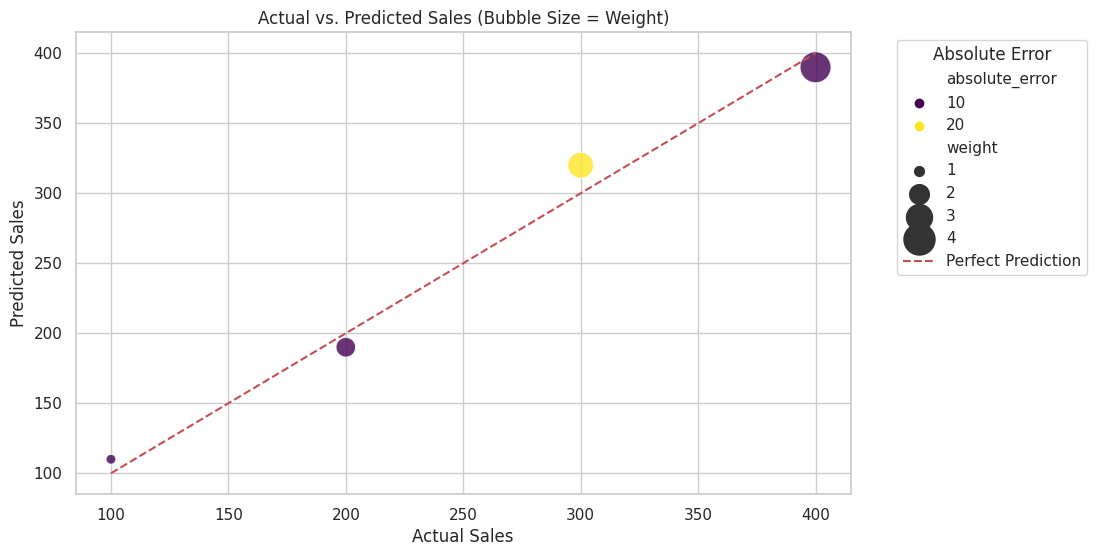

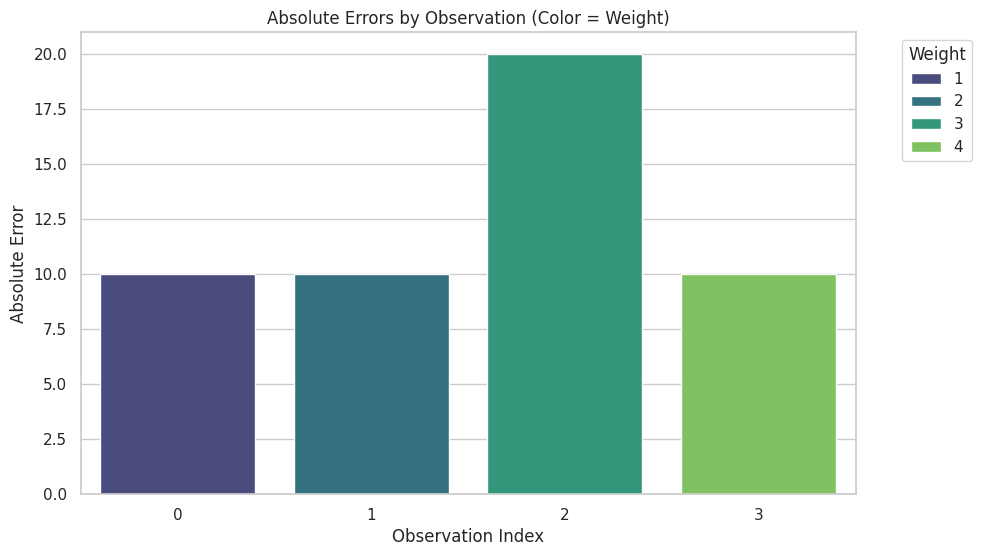

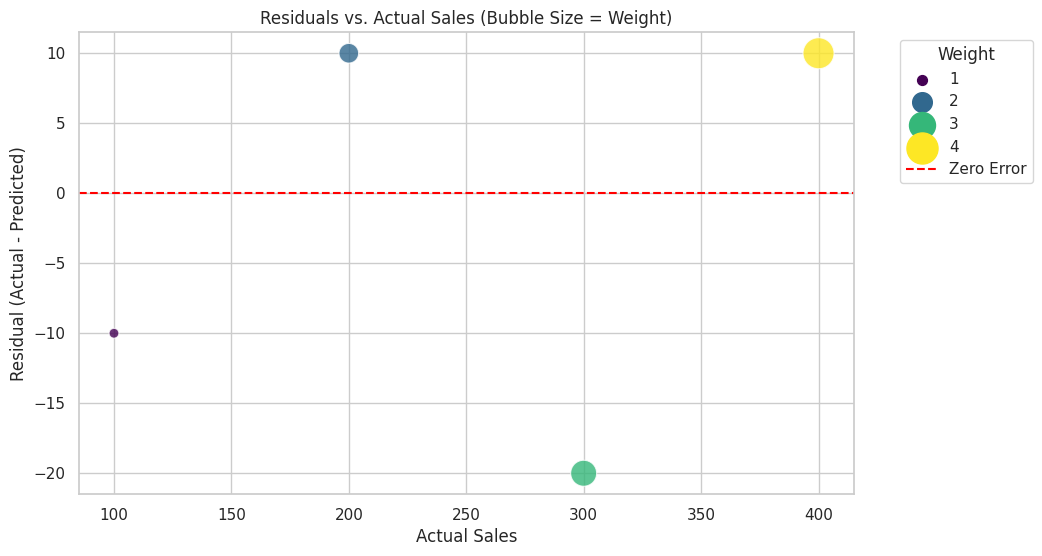

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame (replace with your actual data)
data = {
    'sales': [100, 200, 300, 400],           # Actual sales
    'predicted_sales': [110, 190, 320, 390], # Predicted sales
    'weight': [1, 2, 3, 4]                   # Weights
}
df = pd.DataFrame(data)

# Compute absolute errors
df['absolute_error'] = abs(df['sales'] - df['predicted_sales'])

# Bubble plot: Size = Weight, Color = Absolute Error
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='sales',
    y='predicted_sales',
    size='weight',
    sizes=(50, 500),  # Adjust bubble size range
    hue='absolute_error',
    palette='viridis',
    alpha=0.8
)
plt.plot([df['sales'].min(), df['sales'].max()], 
         [df['sales'].min(), df['sales'].max()], 
         'r--', label='Perfect Prediction')
plt.title('Actual vs. Predicted Sales (Bubble Size = Weight)')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend(title='Absolute Error', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Weighted Absolute Error Bar Plot

# Sort data by weight for clarity
df_sorted = df.sort_values('weight', ascending=False)

# Bar plot of absolute errors, colored by weight
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_sorted,
    x=df_sorted.index,
    y='absolute_error',
    hue='weight',
    palette='viridis',
    dodge=False
)
plt.title('Absolute Errors by Observation (Color = Weight)')
plt.xlabel('Observation Index')
plt.ylabel('Absolute Error')
plt.legend(title='Weight', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Residuals vs. Actual Sales (Weighted)

# Calculate residuals
df['residual'] = df['sales'] - df['predicted_sales']

# Residual plot with weights
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='sales',
    y='residual',
    size='weight',
    sizes=(50, 500),
    hue='weight',
    palette='viridis',
    alpha=0.8
)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.title('Residuals vs. Actual Sales (Bubble Size = Weight)')
plt.xlabel('Actual Sales')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend(title='Weight', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

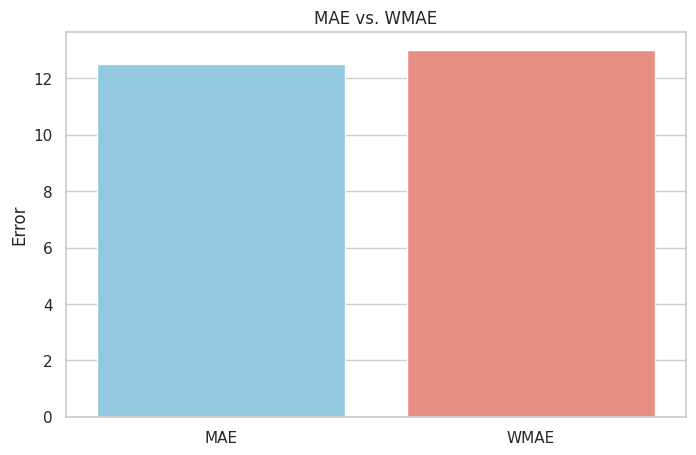

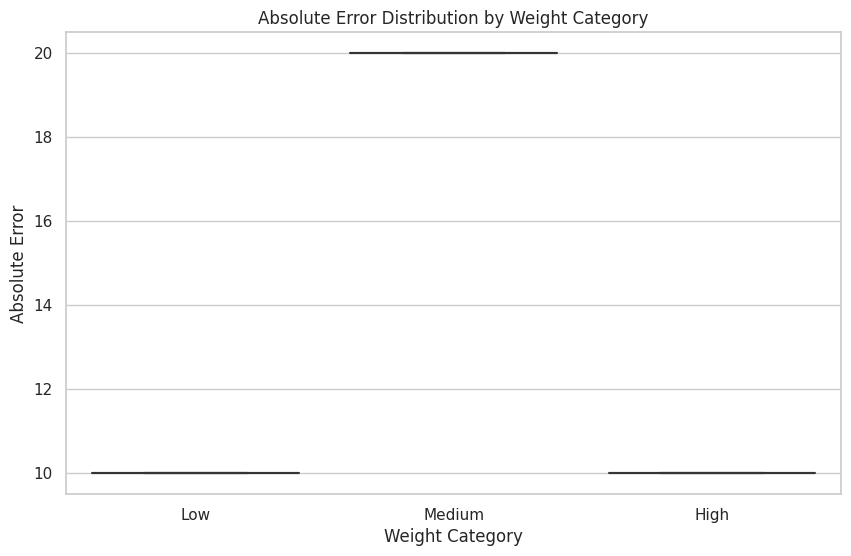

In [96]:
### WMAE vs. MAE Comparison
from sklearn.metrics import mean_absolute_error

# Calculate WMAE and MAE
wmae = mean_absolute_error(df['sales'], df['predicted_sales'], sample_weight=df['weight'])
mae = mean_absolute_error(df['sales'], df['predicted_sales'])

# Bar plot comparison
plt.figure(figsize=(8, 5))
sns.barplot(
    x=['MAE', 'WMAE'],
    y=[mae, wmae],
    palette=['skyblue', 'salmon']
)
plt.title('MAE vs. WMAE')
plt.ylabel('Error')
plt.show()

### Error Distribution by Weight Category
# Bin weights into categories (e.g., Low, Medium, High)
df['weight_category'] = pd.cut(
    df['weight'],
    bins=[0, 2, 3, 5],
    labels=['Low', 'Medium', 'High']
)

# Boxplot of errors by weight category
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='weight_category',
    y='absolute_error',
    palette='viridis'
)
plt.title('Absolute Error Distribution by Weight Category')
plt.xlabel('Weight Category')
plt.ylabel('Absolute Error')
plt.show()